In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.mirror.amaze.com.au/spark/spark-3.0.2/spark-3.0.2-bin-hadoop3.2.tgz
!tar xf spark-3.0.2-bin-hadoop3.2.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.0.2-bin-hadoop3.2"

In [3]:
import findspark
findspark.init()

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import csv
import pyspark.sql
import pandas as pd
from fbprophet import Prophet
import matplotlib as mpl
import matplotlib.pyplot as plt

In [8]:
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

In [9]:
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql.functions import *

In [10]:
# import the necessary pyspark and pandas libraries

from pyspark.sql.functions import pandas_udf, PandasUDFType, current_date
from pyspark.sql.types import StructType,StructField,StringType,LongType,DoubleType,FloatType

import statsmodels.tsa.api as sm
import numpy as np
import pandas as pd

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [12]:
aqi_list = []
for i in range(2000, 2020):
  df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CC_Project/Data/daily_aqi_by_county_{}.csv'.format(str(i)))
  aqi_list.append(df)

aqi_df= pd.concat(aqi_list)
aqi_df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.



,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,Alabama,Baldwin,01,3,2000-01-16,25,Good,PM2.5,01-003-0010,1
1,Alabama,Baldwin,01,3,2000-01-19,46,Good,PM2.5,01-003-0010,1
2,Alabama,Baldwin,01,3,2000-01-22,36,Good,PM2.5,01-003-0010,1
3,Alabama,Baldwin,01,3,2000-01-25,26,Good,PM2.5,01-003-0010,1
4,Alabama,Baldwin,01,3,2000-01-28,32,Good,PM2.5,01-003-0010,1


In [13]:
# converting the col names into lowercase
aqi_df = aqi_df.rename(columns={"State Name" : "state_name", "county Name" : "county_name", "State Code" : "state_code", "County Code" : "county_code", "Date" : "date", "AQI" : "aqi", "Category" : "category", "Defining Parameter" : "defining_parameter", "Defining Site" : "defining_site", "Number of Sites Reporting" : "num_of_sites_reporting"})

In [14]:
aqi_df.head()

,state_name,county_name,state_code,county_code,date,aqi,category,defining_parameter,defining_site,num_of_sites_reporting
0,Alabama,Baldwin,01,3,2000-01-16,25,Good,PM2.5,01-003-0010,1
1,Alabama,Baldwin,01,3,2000-01-19,46,Good,PM2.5,01-003-0010,1
2,Alabama,Baldwin,01,3,2000-01-22,36,Good,PM2.5,01-003-0010,1
3,Alabama,Baldwin,01,3,2000-01-25,26,Good,PM2.5,01-003-0010,1
4,Alabama,Baldwin,01,3,2000-01-28,32,Good,PM2.5,01-003-0010,1


In [15]:
aqi_df['date'] = pd.to_datetime(aqi_df['date'], infer_datetime_format= True)

In [16]:
aqi_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6489592 entries, 0 to 341944
Data columns (total 10 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   state_name              object        
 1   county_name             object        
 2   state_code              object        
 3   county_code             int64         
 4   date                    datetime64[ns]
 5   aqi                     int64         
 6   category                object        
 7   defining_parameter      object        
 8   defining_site           object        
 9   num_of_sites_reporting  int64         
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 544.6+ MB


In [17]:
print("\n Missing values: ", aqi_df.isnull().any())
print("\n Unique values: ", aqi_df.nunique())


 Missing values:  state_name                False
county_name               False
state_code                False
county_code               False
date                      False
aqi                       False
category                  False
defining_parameter        False
defining_site             False
num_of_sites_reporting    False
dtype: bool

 Unique values:  state_name                  55
county_name               1004
state_code                  69
county_code                190
date                      7305
aqi                        812
category                     6
defining_parameter           6
defining_site             4762
num_of_sites_reporting      39
dtype: int64


In [18]:
plot_df = aqi_df.set_index('date')

In [19]:
plot_df['county_code'].value_counts()

3      178501
1      173166
13     152711
5      149643
33     124552
        ...  
235       132
232       125
211       107
130        90
188        21
Name: county_code, Length: 190, dtype: int64

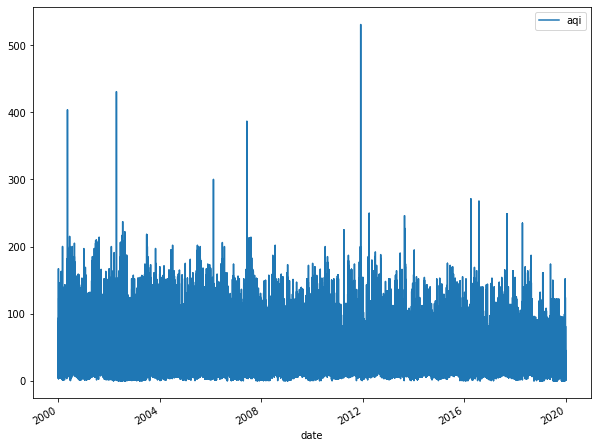

In [20]:
plot_df.query("county_code == 3")[['aqi']].plot()

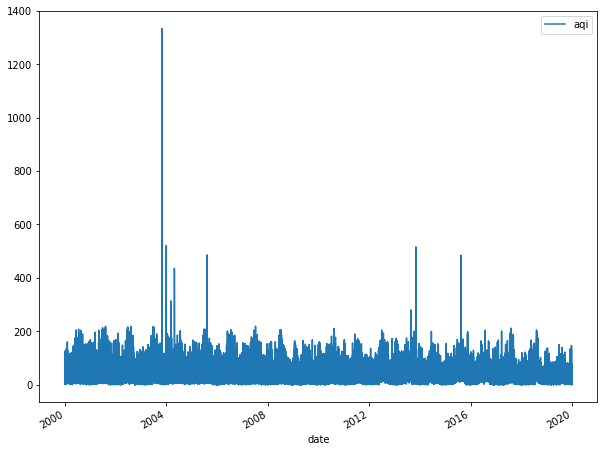

In [21]:
plot_df.query("county_code == 5")[['aqi']].plot()

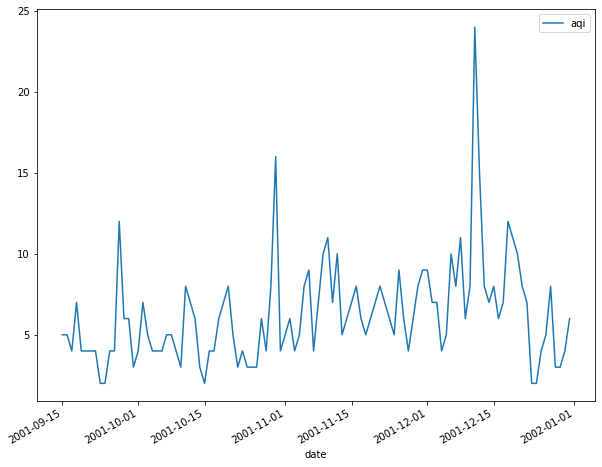

In [22]:
plot_df.query("county_code == 211")[['aqi']].plot()

In [23]:
df = spark.read.csv("/content/drive/MyDrive/Colab Notebooks/CC_Project/Data/*.csv", header=True)
df.show(5)

+----------+-----------+----------+-----------+----------+---+--------+------------------+-------------+-------------------------+
|State Name|county Name|State Code|County Code|      Date|AQI|Category|Defining Parameter|Defining Site|Number of Sites Reporting|
+----------+-----------+----------+-----------+----------+---+--------+------------------+-------------+-------------------------+
|   Alabama|    Baldwin|        01|        003|2018-01-02| 32|    Good|             PM2.5|  01-003-0010|                        1|
|   Alabama|    Baldwin|        01|        003|2018-01-05| 34|    Good|             PM2.5|  01-003-0010|                        1|
|   Alabama|    Baldwin|        01|        003|2018-01-08| 15|    Good|             PM2.5|  01-003-0010|                        1|
|   Alabama|    Baldwin|        01|        003|2018-01-11| 19|    Good|             PM2.5|  01-003-0010|                        1|
|   Alabama|    Baldwin|        01|        003|2018-01-14| 25|    Good|            

In [24]:
df.printSchema()

root
 |-- State Name: string (nullable = true)
 |-- county Name: string (nullable = true)
 |-- State Code: string (nullable = true)
 |-- County Code: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- AQI: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Defining Parameter: string (nullable = true)
 |-- Defining Site: string (nullable = true)
 |-- Number of Sites Reporting: string (nullable = true)



In [25]:
df.show(5)

+----------+-----------+----------+-----------+----------+---+--------+------------------+-------------+-------------------------+
|State Name|county Name|State Code|County Code|      Date|AQI|Category|Defining Parameter|Defining Site|Number of Sites Reporting|
+----------+-----------+----------+-----------+----------+---+--------+------------------+-------------+-------------------------+
|   Alabama|    Baldwin|        01|        003|2018-01-02| 32|    Good|             PM2.5|  01-003-0010|                        1|
|   Alabama|    Baldwin|        01|        003|2018-01-05| 34|    Good|             PM2.5|  01-003-0010|                        1|
|   Alabama|    Baldwin|        01|        003|2018-01-08| 15|    Good|             PM2.5|  01-003-0010|                        1|
|   Alabama|    Baldwin|        01|        003|2018-01-11| 19|    Good|             PM2.5|  01-003-0010|                        1|
|   Alabama|    Baldwin|        01|        003|2018-01-14| 25|    Good|            

In [26]:
state_df = df.filter(df['State Name'] == "California")
cal_aqi = state_df.orderBy("Date")
cal_aqi.show(5)

+----------+------------+----------+-----------+----------+---+--------------------+------------------+-------------+-------------------------+
|State Name| county Name|State Code|County Code|      Date|AQI|            Category|Defining Parameter|Defining Site|Number of Sites Reporting|
+----------+------------+----------+-----------+----------+---+--------------------+------------------+-------------+-------------------------+
|California|   El Dorado|        06|        017|1980-01-01|106|Unhealthy for Sen...|                CO|  06-017-0007|                        4|
|California|     Alameda|        06|        001|1980-01-01| 57|            Moderate|               NO2|  06-001-0004|                        5|
|California|       Glenn|        06|        021|1980-01-01| 20|                Good|             Ozone|  06-021-0001|                        1|
|California|       Butte|        06|        007|1980-01-01| 19|                Good|               NO2|  06-007-0002|                   

In [27]:
cali_df = cal_aqi.select('State Name', 'State Code', 'County Name', 'County Code', 'Date', 'AQI', 'Defining Parameter', 'Category')
cali_df.show(5)

+----------+----------+------------+-----------+----------+---+------------------+--------------------+
|State Name|State Code| County Name|County Code|      Date|AQI|Defining Parameter|            Category|
+----------+----------+------------+-----------+----------+---+------------------+--------------------+
|California|        06|   El Dorado|        017|1980-01-01|106|                CO|Unhealthy for Sen...|
|California|        06|     Alameda|        001|1980-01-01| 57|               NO2|            Moderate|
|California|        06|       Glenn|        021|1980-01-01| 20|             Ozone|                Good|
|California|        06|       Butte|        007|1980-01-01| 19|               NO2|                Good|
|California|        06|Contra Costa|        013|1980-01-01| 57|               NO2|            Moderate|
+----------+----------+------------+-----------+----------+---+------------------+--------------------+
only showing top 5 rows



In [28]:
spark_aqi_df = df.withColumnRenamed("State Name","state_name") \
    .withColumnRenamed("State Code","state_code") \
    .withColumnRenamed("County Name","county_name") \
    .withColumnRenamed("County Code","county_code") \
    .withColumnRenamed("Date","date") \
    .withColumnRenamed("AQI","aqi") \
    .withColumnRenamed("Defining Parameter","defining_parameter") \
    .withColumnRenamed("Category","category")

spark_aqi_df.take(5)

[Row(state_name='Alabama', county_name='Baldwin', state_code='01', county_code='003', date='2018-01-02', aqi='32', category='Good', defining_parameter='PM2.5', Defining Site='01-003-0010', Number of Sites Reporting='1'),
 Row(state_name='Alabama', county_name='Baldwin', state_code='01', county_code='003', date='2018-01-05', aqi='34', category='Good', defining_parameter='PM2.5', Defining Site='01-003-0010', Number of Sites Reporting='1'),
 Row(state_name='Alabama', county_name='Baldwin', state_code='01', county_code='003', date='2018-01-08', aqi='15', category='Good', defining_parameter='PM2.5', Defining Site='01-003-0010', Number of Sites Reporting='1'),
 Row(state_name='Alabama', county_name='Baldwin', state_code='01', county_code='003', date='2018-01-11', aqi='19', category='Good', defining_parameter='PM2.5', Defining Site='01-003-0010', Number of Sites Reporting='1'),
 Row(state_name='Alabama', county_name='Baldwin', state_code='01', county_code='003', date='2018-01-14', aqi='25', c

In [29]:
# converting the Date column datatype from string -> timestamp
spark_aqi_df = spark_aqi_df.withColumn("date", spark_aqi_df["date"].cast(TimestampType()))

In [30]:
spark_aqi_df.schema

StructType(List(StructField(state_name,StringType,true),StructField(county_name,StringType,true),StructField(state_code,StringType,true),StructField(county_code,StringType,true),StructField(date,TimestampType,true),StructField(aqi,StringType,true),StructField(category,StringType,true),StructField(defining_parameter,StringType,true),StructField(Defining Site,StringType,true),StructField(Number of Sites Reporting,StringType,true)))

In [31]:
spark_aqi_df.createOrReplaceTempView("aqi")

In [32]:
sql_df = spark.sql('SELECT county_code, date as ds, sum(aqi) as y FROM aqi GROUP BY county_code, date ORDER BY county_code, date')
sql_df.show()

+-----------+-------------------+------+
|county_code|                 ds|     y|
+-----------+-------------------+------+
|        001|1980-01-01 00:00:00| 691.0|
|        001|1980-01-02 00:00:00| 986.0|
|        001|1980-01-03 00:00:00|1055.0|
|        001|1980-01-04 00:00:00| 823.0|
|        001|1980-01-05 00:00:00| 818.0|
|        001|1980-01-06 00:00:00| 873.0|
|        001|1980-01-07 00:00:00| 626.0|
|        001|1980-01-08 00:00:00| 932.0|
|        001|1980-01-09 00:00:00|1024.0|
|        001|1980-01-10 00:00:00| 973.0|
|        001|1980-01-11 00:00:00| 543.0|
|        001|1980-01-12 00:00:00| 678.0|
|        001|1980-01-13 00:00:00| 659.0|
|        001|1980-01-14 00:00:00| 588.0|
|        001|1980-01-15 00:00:00| 580.0|
|        001|1980-01-16 00:00:00| 757.0|
|        001|1980-01-17 00:00:00| 660.0|
|        001|1980-01-18 00:00:00| 832.0|
|        001|1980-01-19 00:00:00| 747.0|
|        001|1980-01-20 00:00:00| 571.0|
+-----------+-------------------+------+
only showing top

In [33]:
aqi_part = (sql_df.repartition(spark.sparkContext.defaultParallelism, ['county_code'])).cache()

**Training the Model**

In [34]:
aqi_part.explain()

== Physical Plan ==
InMemoryTableScan [county_code#271, ds#347, y#348]
   +- InMemoryRelation [county_code#271, ds#347, y#348], StorageLevel(disk, memory, deserialized, 1 replicas)
         +- Exchange hashpartitioning(county_code#271, 2), false, [id=#141]
            +- *(3) Sort [county_code#271 ASC NULLS FIRST, ds#347 ASC NULLS FIRST], true, 0
               +- Exchange rangepartitioning(county_code#271 ASC NULLS FIRST, ds#347 ASC NULLS FIRST, 200), true, [id=#137]
                  +- *(2) HashAggregate(keys=[county_code#271, date#336], functions=[sum(cast(aqi#293 as double))])
                     +- Exchange hashpartitioning(county_code#271, date#336, 200), true, [id=#133]
                        +- *(1) HashAggregate(keys=[county_code#271, date#336], functions=[partial_sum(cast(aqi#293 as double))])
                           +- *(1) Project [County Code#19 AS county_code#271, cast(Date#20 as timestamp) AS date#336, AQI#21 AS aqi#293]
                              +- FileScan cs

In [61]:
schema = StructType([
                     StructField('ds', TimestampType()),
                     StructField('county_code', StringType()),
                     StructField('y', DoubleType()),
                     StructField('yhat', DoubleType()),
                     StructField('yhat_upper', DoubleType()),
                     StructField('yhat_lower', DoubleType())
                     ])



In [62]:
@pandas_udf(schema, PandasUDFType.GROUPED_MAP)

def forecast_aqi(pd_aqi):
  aqi_model = Prophet(
      interval_width=0.95, 
      seasonality_mode='multiplicative', 
      weekly_seasonality=True, 
      yearly_seasonality=True)
  
  print(aqi_model.history)
  aqi_model.fit(pd_aqi)

  future_pd = aqi_model.make_future_dataframe(periods=5, freq='w')

  forecast_pd = aqi_model.predict(future_pd)
  print(forecast_pd)
  
  f_pd = forecast_pd[['ds','yhat','yhat_upper','yhat_lower']].set_index('ds')
  aq_pd = pd_aqi[['ds', 'county_code', 'y']].set_index('ds')

  results_pd = f_pd.join(aq_pd, how="left")
  results_pd.reset_index(level=0, inplace=True)

  results_pd['county_code'] = pd_aqi['county_code'].iloc[0]

  return results_pd[['ds', 'county_code', 'y', 'yhat', 'yhat_upper', 'yhat_lower']]

In [63]:
aqi_result = (
    aqi_part
    .groupBy('county_code')
    .apply(forecast_aqi)
    .withColumn('training_date', current_date())
)

spark-3.0.2-bin-hadoop3.2/python/pyspark/sql/pandas/group_ops.py:76: UserWarning:

It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.



In [64]:
aqi_result.cache()

DataFrame[ds: timestamp, county_code: string, y: double, yhat: double, yhat_upper: double, yhat_lower: double, training_date: date]

In [65]:
aqi_result.show()

+-------------------+-----------+----+------------------+------------------+------------------+-------------+
|                 ds|county_code|   y|              yhat|        yhat_upper|        yhat_lower|training_date|
+-------------------+-----------+----+------------------+------------------+------------------+-------------+
|1995-05-24 00:00:00|        004|67.0|41.862517003642644|  65.5430706530853|19.887667754686856|   2021-04-27|
|1995-05-25 00:00:00|        004|34.0| 42.72316829249621|  64.6022893939113|20.128892622378032|   2021-04-27|
|1995-05-26 00:00:00|        004|34.0|44.516858354081165| 68.71210306147735| 22.35510663892892|   2021-04-27|
|1995-05-27 00:00:00|        004|33.0| 41.21181379992888| 64.82752717439806|18.870037726341103|   2021-04-27|
|1995-05-28 00:00:00|        004|38.0| 40.92103055443147| 64.63068269754507| 17.77724663473228|   2021-04-27|
|1995-05-29 00:00:00|        004|38.0|40.978121659188346|63.503939006810526| 17.90332191513656|   2021-04-27|
|1995-05-3

**Predicting the future AQI Values**

In [66]:
aqi_result.count()

2035707

In [79]:
aqi_result.createOrReplaceTempView("forecast_aqi")

In [91]:
final_result_df = aqi_result.toPandas()
type(final_result_df)

pandas.core.frame.DataFrame

In [92]:
final_result_df = final_result_df.set_index('ds')

In [94]:
final_result_df

,county_code,y,yhat,yhat_upper,yhat_lower,training_date
ds,,,,,,
1995-05-24,004,67.0,41.862517,65.543071,19.887668,2021-04-27
1995-05-25,004,34.0,42.723168,64.602289,20.128893,2021-04-27
1995-05-26,004,34.0,44.516858,68.712103,22.355107,2021-04-27
1995-05-27,004,33.0,41.211814,64.827527,18.870038,2021-04-27
1995-05-28,004,38.0,40.921031,64.630683,17.777247,2021-04-27
...,...,...,...,...,...,...
2020-10-04,840,NaN,6.489588,21.061663,-8.270917,2021-04-27
2020-10-11,840,NaN,6.581479,21.110171,-7.544153,2021-04-27
2020-10-18,840,NaN,6.794685,20.769463,-7.043763,2021-04-27


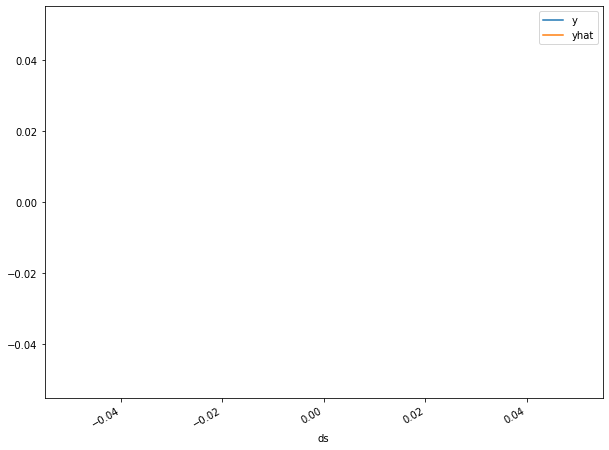

In [97]:
final_result_df.query("county_code == 33")[['y','yhat']].plot()